In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import copy
import pandas as pd
import time

In [2]:
#from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
#from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

In [3]:
from subspace_clustering_helper_funcs import *

- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold

## Loading in the data

In [4]:
# remove pID 101 because it doesn't exist
# remove pID 131 because it  doesnt have enough user defined gestures
# each participant has 100 experimenter defined files and 50 user defined files
# 10 experimenter defined gestures and 5 user defined gestures

file_types = ["IMU_extract", "movavg_files"]
expt_types = ["experimenter-defined"]

#remove participant 131 because they are missing gestures 
pIDs_impaired = ['P102','P103','P104','P105','P106','P107','P108','P109','P110','P111',
       'P112','P114','P115','P116','P118','P119','P121','P122','P123','P124','P125',
       'P126','P127','P128', 'P132']
# remove participants P001 and P003 because they dont have duplicate or open gestures
pIDs_unimpaired = ['P004','P005','P006','P008','P010','P011']

pIDs_both = pIDs_impaired + pIDs_unimpaired

In [5]:
## Pickle is theoretically faster for Python...

# Kai's laptop
data_path = "C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\PCA_40D\\"
# BRC Desktop
#data_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\"

print("Loading")
start_time = time.time()

metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']

PCA_df = pd.read_pickle(data_path+'PCA_ms_IMUEMG_df.pkl')
metadata_cols_df = pd.read_pickle('C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\metadata_cols_df.pkl')

# Dropping the metadata when we read it in!
training_u_df = pd.read_pickle(data_path+'training_u_df.pkl').drop(metadata_cols, axis=1)
test_users_df = pd.read_pickle(data_path+'test_users_df.pkl').drop(metadata_cols, axis=1)

#training_g_df = pd.read_pickle(data_path+'training_g_df.pkl').drop(metadata_cols, axis=1)
#test_fullgestures_df = pd.read_pickle(data_path+'test_fullgestures_df.pkl').drop(metadata_cols, axis=1)

end_time = time.time()
print(f"Completed in {end_time - start_time}s")

Loading
Completed in 4.604297161102295s


In [6]:
print(training_u_df.shape)
training_u_df.head()

(327168, 40)


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.027903,0.001411,-0.019509,0.013428,-0.019699,0.027333,-0.031254,-0.022910,0.066484,0.108729,...,-0.019453,0.062983,-0.025869,0.014303,-0.013387,-0.037645,-0.186270,-0.046251,-0.104630,-0.002939
1,-0.038982,0.006470,-0.000111,0.010904,-0.015323,0.031336,-0.007901,-0.027368,0.060370,0.074712,...,0.041438,0.035053,-0.056843,-0.008895,-0.022542,-0.022563,-0.160826,-0.048161,-0.073771,0.043268
2,-0.116782,0.003824,0.011550,-0.014612,-0.093325,0.081718,-0.013155,-0.046150,0.036385,0.052746,...,-0.014298,0.072109,-0.026536,-0.034365,0.018695,-0.011940,-0.160580,-0.041831,-0.109653,0.027043
3,-0.030245,-0.017409,0.022540,-0.048905,-0.029129,0.090026,-0.024645,-0.064307,0.074589,0.053055,...,-0.010992,0.059990,-0.097073,-0.056870,-0.001038,-0.008015,-0.165858,-0.049424,-0.108671,0.069886
4,-0.112950,0.026262,0.004837,-0.063254,-0.108892,0.198729,-0.010583,-0.124893,0.114817,0.038628,...,0.035735,0.050880,-0.093678,-0.131263,0.018035,0.056185,-0.157963,-0.041911,-0.145308,0.063311


In [7]:
print(test_users_df.shape)
test_users_df.head()

(99584, 40)


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
11520,0.068817,0.042105,-0.044102,0.053256,0.080938,0.106052,-0.022074,0.036360,-0.069783,-0.009365,...,0.063422,0.081947,0.101682,-0.190886,-0.128849,-0.133675,-0.141095,-0.068262,-0.032521,0.018558
11521,0.074061,0.047283,-0.042408,0.054238,0.074058,0.102463,-0.015359,0.038657,-0.073921,-0.017769,...,0.072693,0.087035,0.107107,-0.189667,-0.127273,-0.140950,-0.143033,-0.066269,-0.033821,0.018198
11522,0.079972,0.043184,-0.055275,0.046477,0.079097,0.100367,-0.017235,0.037957,-0.077119,-0.026219,...,0.071150,0.081851,0.103781,-0.186400,-0.119714,-0.137523,-0.143988,-0.064562,-0.036610,0.016388
11523,0.066582,0.035923,-0.040610,0.045127,0.083319,0.103084,-0.026479,0.037962,-0.074883,-0.020225,...,0.065488,0.077696,0.100158,-0.195122,-0.128462,-0.133530,-0.147047,-0.064546,-0.032468,0.015712
11524,0.070243,0.048672,-0.050055,0.045911,0.075328,0.102190,-0.026261,0.038253,-0.068708,-0.025581,...,0.064663,0.082686,0.104846,-0.185309,-0.126085,-0.138847,-0.147857,-0.067871,-0.031347,0.019686


Let's actually re-arrange to make them 3D matrices...

In [8]:
num_rows_per_gesture = 64 # From the interp
num_gestures = len(PCA_df) // num_rows_per_gesture
num_features = PCA_df.shape[1]

# Ensure the data can be evenly divided into gestures
assert len(PCA_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Convert DataFrame to NumPy array
data_np = PCA_df.to_numpy()
# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns)
PCA_np = data_np.reshape(num_gestures, num_rows_per_gesture, num_features)
#PCA_np = PCA_df.to_numpy()
#flattened_PCA = PCA_np.reshape(num_gestures, -1)

In [9]:
PCA_np.shape

(6668, 64, 40)

In [10]:
PCA_df = pd.concat([metadata_cols_df, PCA_df], axis=1)
PCA_df.head()

,Participant,Gesture_ID,Gesture_Num,0,1,2,3,4,5,6,...,30,31,32,33,34,35,36,37,38,39
0,P102,pan,1,-0.027903,0.001411,-0.019509,0.013428,-0.019699,0.027333,-0.031254,...,-0.019453,0.062983,-0.025869,0.014303,-0.013387,-0.037645,-0.186270,-0.046251,-0.104630,-0.002939
1,P102,pan,1,-0.038982,0.006470,-0.000111,0.010904,-0.015323,0.031336,-0.007901,...,0.041438,0.035053,-0.056843,-0.008895,-0.022542,-0.022563,-0.160826,-0.048161,-0.073771,0.043268
2,P102,pan,1,-0.116782,0.003824,0.011550,-0.014612,-0.093325,0.081718,-0.013155,...,-0.014298,0.072109,-0.026536,-0.034365,0.018695,-0.011940,-0.160580,-0.041831,-0.109653,0.027043
3,P102,pan,1,-0.030245,-0.017409,0.022540,-0.048905,-0.029129,0.090026,-0.024645,...,-0.010992,0.059990,-0.097073,-0.056870,-0.001038,-0.008015,-0.165858,-0.049424,-0.108671,0.069886
4,P102,pan,1,-0.112950,0.026262,0.004837,-0.063254,-0.108892,0.198729,-0.010583,...,0.035735,0.050880,-0.093678,-0.131263,0.018035,0.056185,-0.157963,-0.041911,-0.145308,0.063311


In [11]:
#flattened_PCA.shape

# Dataset Differences: Which users perform which gestures?

In [12]:
# Script 1: Identify all gestures that all users do
user_gestures = PCA_df.groupby('Participant')['Gesture_ID'].apply(set)
common_gestures = set.intersection(*user_gestures)
print(f"Gestures that all users do: {common_gestures}")


Gestures that all users do: {'select-single', 'gesture-2', 'pan', 'delete', 'zoom-out', 'gesture-3', 'zoom-in', 'rotate', 'gesture-4', 'normal', 'gesture-1', 'frequency', 'open', 'move', 'gesture-5', 'close', 'duplicate', 'range-of-motion'}


In [23]:
num_users = len(PCA_df['Participant'].unique())

In [24]:
# Script 2: Report which users do each gesture
gesture_users = PCA_df.groupby('Gesture_ID')['Participant'].apply(set)
print("Each gesture is performed by the following users:\n")
all_users_lst = []
for gesture_id, users in gesture_users.items():
    print(f"{gesture_id} performed by {len(users)} users: {users}\n")
    if len(users)==num_users: #31 is all users!
        all_users_lst.append(gesture_id)
        

Each gesture is performed by the following users:

air-tap performed by 16 users: {'P124', 'P114', 'P116', 'P126', 'P132', 'P011', 'P004', 'P010', 'P105', 'P119', 'P008', 'P006', 'P123', 'P005', 'P111', 'P104'}

close performed by 31 users: {'P106', 'P126', 'P108', 'P127', 'P105', 'P119', 'P008', 'P118', 'P115', 'P111', 'P102', 'P109', 'P128', 'P110', 'P005', 'P107', 'P124', 'P121', 'P116', 'P132', 'P011', 'P004', 'P010', 'P122', 'P123', 'P006', 'P114', 'P112', 'P125', 'P103', 'P104'}

delete performed by 31 users: {'P106', 'P126', 'P108', 'P127', 'P105', 'P119', 'P008', 'P118', 'P115', 'P111', 'P102', 'P109', 'P128', 'P110', 'P005', 'P107', 'P124', 'P121', 'P116', 'P132', 'P011', 'P004', 'P010', 'P122', 'P123', 'P006', 'P114', 'P112', 'P125', 'P103', 'P104'}

double-clench performed by 6 users: {'P011', 'P004', 'P010', 'P008', 'P005', 'P006'}

double-pinch performed by 6 users: {'P011', 'P004', 'P010', 'P008', 'P005', 'P006'}

duplicate performed by 31 users: {'P106', 'P126', 'P108', 

Limiting it to just the gestures that all users perform:

In [25]:
all_users_lst

['close',
 'delete',
 'duplicate',
 'frequency',
 'gesture-1',
 'gesture-2',
 'gesture-3',
 'gesture-4',
 'gesture-5',
 'move',
 'normal',
 'open',
 'pan',
 'range-of-motion',
 'rotate',
 'select-single',
 'zoom-in',
 'zoom-out']

In [27]:
gestures_perf_by_all_users_df = PCA_df[PCA_df['Gesture_ID'].isin(all_users_lst)]

In [30]:
gestures_perf_by_all_users_df.shape[0]/64

5570.0

In [31]:
gestures_perf_by_all_users_df.shape[0]/64/31

179.67741935483872

In [32]:
# Group by User ID and Gesture ID, then count unique Gesture Num
gesture_counts = gestures_perf_by_all_users_df.groupby(['Participant', 'Gesture_ID'])['Gesture_Num'].nunique().reset_index()

# Count the number of unique gesture types each user performs
unique_gesture_types = gesture_counts.groupby('Participant')['Gesture_ID'].nunique().reset_index(name='Unique Gesture Types')

# Count the total number of gestures each user performs (total number of gesture trials)
total_gestures = gesture_counts.groupby('Participant')['Gesture_Num'].sum().reset_index(name='Total Gestures')

# Merge the results into a single DataFrame for better readability
user_gesture_stats = pd.merge(unique_gesture_types, total_gestures, on='Participant')

# Display the result
print(user_gesture_stats)


   Participant  Unique Gesture Types  Total Gestures
0         P004                    18             180
1         P005                    18             180
2         P006                    18             180
3         P008                    18             180
4         P010                    18             180
5         P011                    18             180
6         P102                    18             180
7         P103                    18             180
8         P104                    18             180
9         P105                    18             180
10        P106                    18             180
11        P107                    18             180
12        P108                    18             180
13        P109                    18             180
14        P110                    18             180
15        P111                    18             180
16        P112                    18             180
17        P114                    18          

Okay, so most people perform 180 gestures, and a few perform 177. So perhaps we can just drop 3 gestures from the 180 users so that everyone is doing the same 177? Need to double check that each user is actually performing the same gestures the same number of times, eg that user 1 isn't doing gesture 1 like 50 times and gesture 2 10 times, and user 2 is doing the reverse (and thus would end up with the same number of total gestures and unique gesture types)

Identify the users with missing gestures and figure out which gestures those were

In [37]:
# Group by User ID, Gesture ID, and Gesture Num to find the count of gestures each user performs
gesture_counts = gestures_perf_by_all_users_df.groupby(['Participant', 'Gesture_ID', 'Gesture_Num']).size().reset_index(name='Count')

# Find users with fewer than 180 gestures
user_gesture_counts = gesture_counts.groupby('Participant').size().reset_index(name='Total Gestures')
incomplete_users = user_gesture_counts[user_gesture_counts['Total Gestures'] < 180]['Participant']

# Find which gestures are missing for these users
missing_gestures = {}
for user in incomplete_users:
    user_gestures = gesture_counts[gesture_counts['Participant'] == user][['Gesture_ID', 'Gesture_Num']]
    all_gestures = gesture_counts[['Gesture_ID', 'Gesture_Num']].drop_duplicates()
    missing_gestures[user] = pd.merge(all_gestures, user_gestures, on=['Gesture_ID', 'Gesture_Num'], how='left', indicator=True)
    missing_gestures[user] = missing_gestures[user][missing_gestures[user]['_merge'] == 'left_only'][['Gesture_ID', 'Gesture_Num']]

print("Missing Gestures for Users with Fewer Than 180 Gestures:")
for user, missing in missing_gestures.items():
    print(f"User {user} is missing the following gestures:")
    print(missing)
    print()

Missing Gestures for Users with Fewer Than 180 Gestures:
User P114 is missing the following gestures:
    Gesture_ID Gesture_Num
106     normal           6
107     normal           7
129        pan           9

User P122 is missing the following gestures:
   Gesture_ID Gesture_Num
87  gesture-5           7

User P123 is missing the following gestures:
    Gesture_ID Gesture_Num
44   gesture-1           4
127        pan           7
177   zoom-out           7

User P127 is missing the following gestures:
        Gesture_ID Gesture_Num
153  select-single           3
167        zoom-in           7
176       zoom-out           6



Creating a consistent dataset (one for each user) that has the same number of gestures and types of gestures, in corresponding rows

In [ ]:
# Group by User ID, Gesture ID, and Gesture Num to find the count of gestures each user performs
gesture_counts = gestures_perf_by_all_users_df.groupby(['User ID', 'Gesture ID', 'Gesture Num']).size().reset_index(name='Count')

# Find users with fewer than 180 gestures
user_gesture_counts = gesture_counts.groupby('User ID').size().reset_index(name='Total Gestures')
incomplete_users = user_gesture_counts[user_gesture_counts['Total Gestures'] < 180]['User ID']

# Find which gestures are missing for these users
missing_gestures = {}
for user in incomplete_users:
    user_gestures = gesture_counts[gesture_counts['User ID'] == user][['Gesture ID', 'Gesture Num']]
    all_gestures = gesture_counts[['Gesture ID', 'Gesture Num']].drop_duplicates()
    missing_gestures[user] = pd.merge(all_gestures, user_gestures, on=['Gesture ID', 'Gesture Num'], how='left', indicator=True)
    missing_gestures[user] = missing_gestures[user][missing_gestures[user]['_merge'] == 'left_only'][['Gesture ID', 'Gesture Num']]

print("Missing Gestures for Users with Fewer Than 180 Gestures:")
for user, missing in missing_gestures.items():
    print(f"User {user} is missing the following gestures:")
    print(missing)

Me editing it to make the rows correct:

In [ ]:
# Find the minimum number of gestures any user performs
min_gestures = 177

# Create a consistent dataset
consistent_datasets = {}

for user_id in gestures_perf_by_all_users_df['Participant'].unique():
    user_data = gestures_perf_by_all_users_df[gestures_perf_by_all_users_df['Participant'] == user_id]
    
    # Drop the missing gestures from all users
    if user_id in missing_gestures:
        gestures_to_drop = missing_gestures[user_id]
        for _, row in gestures_to_drop.iterrows():
            user_data = user_data[~((user_data['Gesture_ID'] == row['Gesture_ID']) & (user_data['Gesture_Num'] == row['Gesture_Num']))]
    
    consistent_datasets[user_id] = user_data

# Verify the consistency of the dataset for each user
for user_id, data in consistent_datasets.items():
    print(f"User {user_id} dataset has {len(data)} gestures")

# Example of accessing the consistent dataset for a specific user
user_id = list(consistent_datasets.keys())[0]
consistent_user_data = consistent_datasets[user_id]


In [53]:
# From missing gestures, extract a set of all the missing gestures (without the IDs): 
## eg gesture_ID and gesture_num pair to uniquely specify which gestures

# Initialize an empty set to store unique missing (Gesture_ID, Gesture_Num) tuples
missing_gestures_tuples_set = set()

# Iterate over the dictionary and add each missing gesture tuple to the set
for user, missing in missing_gestures.items():
    for _, row in missing.iterrows():
        missing_gestures_tuples_set.add((row['Gesture_ID'], row['Gesture_Num']))

# Convert the set to a list for display purposes (optional)
missing_gesture_tuples_lst = list(missing_gestures_tuples_set)

# Print the unique missing gestures
print("Unique missing (Gesture_ID, Gesture_Num) tuples:")
for gesture in missing_gesture_tuples_lst:
    print(gesture)

Unique missing (Gesture_ID, Gesture_Num) tuples:
('normal', '6')
('gesture-1', '4')
('zoom-in', '7')
('gesture-5', '7')
('zoom-out', '7')
('zoom-out', '6')
('pan', '7')
('select-single', '3')
('pan', '9')
('normal', '7')


Now drop these specific gestures from every single user so all users have the same size dataset!

In [ ]:
# I THINK THIS HAS ALREADY BEEN RUN?

'''
# Group by User ID, Gesture ID, and Gesture Num to find the count of gestures each user performs
gesture_counts = gestures_perf_by_all_users_df.groupby(['User ID', 'Gesture ID', 'Gesture Num']).size().reset_index(name='Count')

# Find users with fewer than 180 gestures
user_gesture_counts = gesture_counts.groupby('User ID').size().reset_index(name='Total Gestures')
incomplete_users = user_gesture_counts[user_gesture_counts['Total Gestures'] < 180]['User ID']

# Find which gestures are missing for these users
missing_gestures = {}
for user in incomplete_users:
    user_gestures = gesture_counts[gesture_counts['User ID'] == user][['Gesture ID', 'Gesture Num']]
    all_gestures = gesture_counts[['Gesture ID', 'Gesture Num']].drop_duplicates()
    missing_gestures[user] = pd.merge(all_gestures, user_gestures, on=['Gesture ID', 'Gesture Num'], how='left', indicator=True)
    missing_gestures[user] = missing_gestures[user][missing_gestures[user]['_merge'] == 'left_only'][['Gesture ID', 'Gesture Num']]

# Initialize an empty set to store unique missing (Gesture_ID, Gesture_Num) tuples
missing_gesture_set = set()

# Iterate over the dictionary and add each missing gesture tuple to the set
for user, missing in missing_gestures.items():
    for _, row in missing.iterrows():
        missing_gesture_set.add((row['Gesture ID'], row['Gesture Num']))

# Convert the set to a list for display purposes (optional)
missing_gesture_list = list(missing_gesture_set)
'''
0

In [143]:
missing_gesture_list = missing_gesture_tuples_lst

# Now drop these gestures from every user's dataset
# Create a consistent dataset with the remaining gestures
consistent_datasets = {}

for user_id in gestures_perf_by_all_users_df['Participant'].unique():
    user_data = gestures_perf_by_all_users_df[gestures_perf_by_all_users_df['Participant'] == user_id].copy()
    
    # Drop gestures corresponding to the unique missing tuples
    for gesture_id, gesture_num in missing_gesture_set:
        user_data = user_data[~((user_data['Gesture_ID'] == gesture_id) & (user_data['Gesture_Num'] == gesture_num))].reset_index(drop=True)
    
    consistent_datasets[user_id] = user_data

# Verify the consistency of the dataset for each user
for user_id, data in consistent_datasets.items():
    print(f"User {user_id} dataset has {len(data)} rows ({len(data)/64} gestures) after dropping missing gestures")

# Example of accessing the consistent dataset for a specific user
user_id = list(consistent_datasets.keys())[0]
consistent_user_data = consistent_datasets[user_id]


User P102 dataset has 10880 rows (170.0 gestures) after dropping missing gestures
User P103 dataset has 10880 rows (170.0 gestures) after dropping missing gestures
User P104 dataset has 10880 rows (170.0 gestures) after dropping missing gestures
User P105 dataset has 10880 rows (170.0 gestures) after dropping missing gestures
User P106 dataset has 10880 rows (170.0 gestures) after dropping missing gestures
User P107 dataset has 10880 rows (170.0 gestures) after dropping missing gestures
User P108 dataset has 10880 rows (170.0 gestures) after dropping missing gestures
User P109 dataset has 10880 rows (170.0 gestures) after dropping missing gestures
User P110 dataset has 10880 rows (170.0 gestures) after dropping missing gestures
User P111 dataset has 10880 rows (170.0 gestures) after dropping missing gestures
User P112 dataset has 10880 rows (170.0 gestures) after dropping missing gestures
User P114 dataset has 10880 rows (170.0 gestures) after dropping missing gestures
User P115 datase

In [144]:
print(f"Consistent dataset for User {user_id}:")
print(consistent_user_data.shape)
consistent_user_data.head()

Consistent dataset for User P102:
(10880, 43)


,Participant,Gesture_ID,Gesture_Num,0,1,2,3,4,5,6,...,30,31,32,33,34,35,36,37,38,39
0,P102,pan,1,-0.027903,0.001411,-0.019509,0.013428,-0.019699,0.027333,-0.031254,...,-0.019453,0.062983,-0.025869,0.014303,-0.013387,-0.037645,-0.186270,-0.046251,-0.104630,-0.002939
1,P102,pan,1,-0.038982,0.006470,-0.000111,0.010904,-0.015323,0.031336,-0.007901,...,0.041438,0.035053,-0.056843,-0.008895,-0.022542,-0.022563,-0.160826,-0.048161,-0.073771,0.043268
2,P102,pan,1,-0.116782,0.003824,0.011550,-0.014612,-0.093325,0.081718,-0.013155,...,-0.014298,0.072109,-0.026536,-0.034365,0.018695,-0.011940,-0.160580,-0.041831,-0.109653,0.027043
3,P102,pan,1,-0.030245,-0.017409,0.022540,-0.048905,-0.029129,0.090026,-0.024645,...,-0.010992,0.059990,-0.097073,-0.056870,-0.001038,-0.008015,-0.165858,-0.049424,-0.108671,0.069886
4,P102,pan,1,-0.112950,0.026262,0.004837,-0.063254,-0.108892,0.198729,-0.010583,...,0.035735,0.050880,-0.093678,-0.131263,0.018035,0.056185,-0.157963,-0.041911,-0.145308,0.063311


Unit test: make sure all users have all the same gestures, all the same number of gesture trials for each gesture, and all the gestures are in the same order (eg, that user datasets can be directly compared)

In [145]:
# Step 1: Create a set of all (Gesture_ID, Gesture_Num) tuples for each user
user_gesture_tuples = {}
for user_id, data in consistent_datasets.items():
    user_gesture_tuples[user_id] = set(zip(data['Gesture_ID'], data['Gesture_Num']))

# Step 2: Ensure each user has all the tuples present
reference_tuples = user_gesture_tuples[list(consistent_datasets.keys())[0]]

all_users_have_same_tuples = True
for user_id, tuples in user_gesture_tuples.items():
    if tuples != reference_tuples:
        all_users_have_same_tuples = False
        print(f"User {user_id} does not have the same gesture tuples.")
    else:
        print(f"User {user_id} has the same gesture tuples.")

# Step 3: Ensure all tuples are in the same order for all users
order_consistency = True
reference_order = consistent_datasets[list(consistent_datasets.keys())[0]].sort_values(by=['Gesture_ID', 'Gesture_Num']).reset_index(drop=True)
for user_id, data in consistent_datasets.items():
    user_order = data.sort_values(by=['Gesture_ID', 'Gesture_Num']).reset_index(drop=True)
    if not user_order.equals(reference_order):
        order_consistency = False
        print(f"User {user_id} does not have the same gesture order.")
    else:
        print(f"User {user_id} has the same gesture order.")

if all_users_have_same_tuples and order_consistency:
    print("All users have the same gesture tuples in the same order.")
else:
    print("There are discrepancies in gesture tuples or their order among users.")

User P102 has the same gesture tuples.
User P103 has the same gesture tuples.
User P104 has the same gesture tuples.
User P105 has the same gesture tuples.
User P106 has the same gesture tuples.
User P107 has the same gesture tuples.
User P108 has the same gesture tuples.
User P109 has the same gesture tuples.
User P110 has the same gesture tuples.
User P111 has the same gesture tuples.
User P112 has the same gesture tuples.
User P114 has the same gesture tuples.
User P115 has the same gesture tuples.
User P116 has the same gesture tuples.
User P118 has the same gesture tuples.
User P119 has the same gesture tuples.
User P121 has the same gesture tuples.
User P122 has the same gesture tuples.
User P123 has the same gesture tuples.
User P124 has the same gesture tuples.
User P125 has the same gesture tuples.
User P126 has the same gesture tuples.
User P127 has the same gesture tuples.
User P128 has the same gesture tuples.
User P132 has the same gesture tuples.
User P004 has the same ge

Not very confident in the above analysis. I think the order is actually the same for all users. This is confirmed below

In [146]:
# Initialize an empty list to store unique (Gesture_ID, Gesture_Num) tuples
unique_gestures_list = []

# Iterate over the data and add each unique gesture tuple to the list
for user_id, data in consistent_datasets.items():
    for index, row in data[['Gesture_ID', 'Gesture_Num']].drop_duplicates().iterrows():
        unique_gestures_list.append((row['Gesture_ID'], row['Gesture_Num']))

# Remove duplicates from the list
unique_gestures_list = list(set(unique_gestures_list))

# Sort the unique gestures list
unique_gestures_list.sort()

# Create a DataFrame with rows as integers and columns as user IDs
gesture_user_df = pd.DataFrame(index=range(len(unique_gestures_list)), columns=consistent_datasets.keys())

# Populate the DataFrame with the corresponding tuple from the original datasets
for user_id, data in consistent_datasets.items():
    for i, gesture in enumerate(unique_gestures_list):
        gesture_row = data[(data['Gesture_ID'] == gesture[0]) & (data['Gesture_Num'] == gesture[1])]
        if not gesture_row.empty:
            gesture_user_df.loc[i, user_id] = gesture


In [147]:
# Set display options to show all rows and columns
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

# Display the DataFrame
gesture_user_df.head(200)

,P102,P103,P104,P105,P106,P107,P108,P109,P110,P111,...,P126,P127,P128,P132,P004,P005,P006,P008,P010,P011
0,"(close, 1)","(close, 1)","(close, 1)","(close, 1)","(close, 1)","(close, 1)","(close, 1)","(close, 1)","(close, 1)","(close, 1)",...,"(close, 1)","(close, 1)","(close, 1)","(close, 1)","(close, 1)","(close, 1)","(close, 1)","(close, 1)","(close, 1)","(close, 1)"
1,"(close, 10)","(close, 10)","(close, 10)","(close, 10)","(close, 10)","(close, 10)","(close, 10)","(close, 10)","(close, 10)","(close, 10)",...,"(close, 10)","(close, 10)","(close, 10)","(close, 10)","(close, 10)","(close, 10)","(close, 10)","(close, 10)","(close, 10)","(close, 10)"
2,"(close, 2)","(close, 2)","(close, 2)","(close, 2)","(close, 2)","(close, 2)","(close, 2)","(close, 2)","(close, 2)","(close, 2)",...,"(close, 2)","(close, 2)","(close, 2)","(close, 2)","(close, 2)","(close, 2)","(close, 2)","(close, 2)","(close, 2)","(close, 2)"
3,"(close, 3)","(close, 3)","(close, 3)","(close, 3)","(close, 3)","(close, 3)","(close, 3)","(close, 3)","(close, 3)","(close, 3)",...,"(close, 3)","(close, 3)","(close, 3)","(close, 3)","(close, 3)","(close, 3)","(close, 3)","(close, 3)","(close, 3)","(close, 3)"
4,"(close, 4)","(close, 4)","(close, 4)","(close, 4)","(close, 4)","(close, 4)","(close, 4)","(close, 4)","(close, 4)","(close, 4)",...,"(close, 4)","(close, 4)","(close, 4)","(close, 4)","(close, 4)","(close, 4)","(close, 4)","(close, 4)","(close, 4)","(close, 4)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,"(zoom-out, 3)","(zoom-out, 3)","(zoom-out, 3)","(zoom-out, 3)","(zoom-out, 3)","(zoom-out, 3)","(zoom-out, 3)","(zoom-out, 3)","(zoom-out, 3)","(zoom-out, 3)",...,"(zoom-out, 3)","(zoom-out, 3)","(zoom-out, 3)","(zoom-out, 3)","(zoom-out, 3)","(zoom-out, 3)","(zoom-out, 3)","(zoom-out, 3)","(zoom-out, 3)","(zoom-out, 3)"
166,"(zoom-out, 4)","(zoom-out, 4)","(zoom-out, 4)","(zoom-out, 4)","(zoom-out, 4)","(zoom-out, 4)","(zoom-out, 4)","(zoom-out, 4)","(zoom-out, 4)","(zoom-out, 4)",...,"(zoom-out, 4)","(zoom-out, 4)","(zoom-out, 4)","(zoom-out, 4)","(zoom-out, 4)","(zoom-out, 4)","(zoom-out, 4)","(zoom-out, 4)","(zoom-out, 4)","(zoom-out, 4)"
167,"(zoom-out, 5)","(zoom-out, 5)","(zoom-out, 5)","(zoom-out, 5)","(zoom-out, 5)","(zoom-out, 5)","(zoom-out, 5)","(zoom-out, 5)","(zoom-out, 5)","(zoom-out, 5)",...,"(zoom-out, 5)","(zoom-out, 5)","(zoom-out, 5)","(zoom-out, 5)","(zoom-out, 5)","(zoom-out, 5)","(zoom-out, 5)","(zoom-out, 5)","(zoom-out, 5)","(zoom-out, 5)"
168,"(zoom-out, 8)","(zoom-out, 8)","(zoom-out, 8)","(zoom-out, 8)","(zoom-out, 8)","(zoom-out, 8)","(zoom-out, 8)","(zoom-out, 8)","(zoom-out, 8)","(zoom-out, 8)",...,"(zoom-out, 8)","(zoom-out, 8)","(zoom-out, 8)","(zoom-out, 8)","(zoom-out, 8)","(zoom-out, 8)","(zoom-out, 8)","(zoom-out, 8)","(zoom-out, 8)","(zoom-out, 8)"


In [148]:
# Reset display options to default values
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [149]:
# Iterate over each row in the DataFrame
for index, row in gesture_user_df.iterrows():
    # Iterate over each user column (except the first one)
    for user_id, tuple_value in row.iloc[1:].items():
        # Compare the tuple value with the tuple value in the first column
        if tuple_value != row[gesture_user_df.columns[0]]:
            # Print or store the information about the differing tuples
            print(f"Difference found at row {index}, user {user_id}: {tuple_value} (User {user_id}) vs {row[gesture_user_df.columns[0]]} (User {gesture_user_df.columns[0]})")


So now it's saying that there are no discrepancies...

## Hierarchy / Dendrogram
Now, let's investigate a more informed choice, based on measured statistical heterogenity. Could look at Shannon or KL divergence (heatmap), but I'll just look at a dendogram for now.

In [150]:
# Example of accessing the consistent dataset for a specific user
user_id = list(consistent_datasets.keys())[0]
consistent_user_data = consistent_datasets[user_id]

metric: The distance metric to use. The distance function can be ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulczynski1’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
> How to choose one... equations are listed and briefely explained in the above docs. Implications/consequences are not covered tho

In [162]:
def calculate_distance(df1, df2, distance_metric='euclidean'):
    """
    Calculate the distance between two sets of gesture data.

    Parameters:
    - df1: DataFrame containing gesture data for the first user.
    - df2: DataFrame containing gesture data for the second user.
    - distance_metric: The distance metric to use. Default is 'euclidean'. Other options include 'cosine', 'correlation', etc.

    Returns:
    - distance: The distance between the two sets of gesture data.
    """

    # Extract the raw gesture data (assuming 'Data' column contains the raw data)
    gestures1 = df1.iloc[:, 3:]
    gestures2 = df2.iloc[:, 3:]

    # Calculate the distance based on the chosen metric
    if distance_metric == 'euclidean':
        distance = np.linalg.norm(gestures1 - gestures2)
        #print(distance)
    # You can add other distance metrics here
    elif distance_metric == 'cosine':
        # Calculate cosine similarity
        distance = np.dot(gestures1, gestures2) / (np.linalg.norm(gestures1) * np.linalg.norm(gestures2))
    # Add more distance metrics as needed
    else:
        raise ValueError(f"{distance_metric} not supported yet")

    return distance

from itertools import combinations

def calculate_inter_user_distances(dataframes, distance_metric='euclidean'):
    """
    Calculate the inter-user distance matrix based on raw gesture data.

    Parameters:
    - dataframes: A dictionary where keys are user IDs and values are DataFrames containing gesture data.
    - distance_metric: The distance metric to use. Default is 'euclidean'. Other options include 'cosine', 'correlation', etc.

    Returns:
    - inter_user_distances: A square matrix containing the inter-user distances.
    """

    # Initialize an empty matrix to store inter-user distances
    num_users = len(dataframes)
    inter_user_distances = np.zeros((num_users, num_users))

    ## Generate combinations of users
    #user_combinations = combinations(dataframes.keys(), 2)
    # Calculate distances between each pair of users
    #for i, (user_id1, user_id2) in enumerate(user_combinations):
    #    # Get the respective DataFrames for the pair of users
    #    df1 = dataframes[user_id1]
    #    df2 = dataframes[user_id2]
    #    # Calculate the distance between two users' gesture data
    #    distance = calculate_distance(df1, df2, distance_metric)
    #    row_index = i // num_users
    #    column_index = i % num_users
    #    # Assign the distance to the corresponding positions in the matrix
    #    inter_user_distances[row_index, column_index] = distance
    #    inter_user_distances[column_index, row_index] = distance

    for i, (user_id1, df1) in enumerate(dataframes.items()):
        for j, (user_id2, df2) in enumerate(dataframes.items()):
            # Calculate the distance between two users' gesture data
            distance = calculate_distance(df1, df2, distance_metric)

            # Assign the distance to the corresponding positions in the matrix
            inter_user_distances[i, j] = distance
            inter_user_distances[j, i] = distance  # Symmetric assignment

    return inter_user_distances


In [163]:
num_users = len(list(consistent_datasets.keys()))

In [164]:
# Create a dictionary with user IDs as keys and DataFrames as values
#dataframes = {'user1': user1_data, 'user2': user2_data, 'user3': user3_data}
dataframes = consistent_datasets

# Calculate inter-user distances using Euclidean distance
user_distances = calculate_inter_user_distances(dataframes, distance_metric='euclidean')


Average

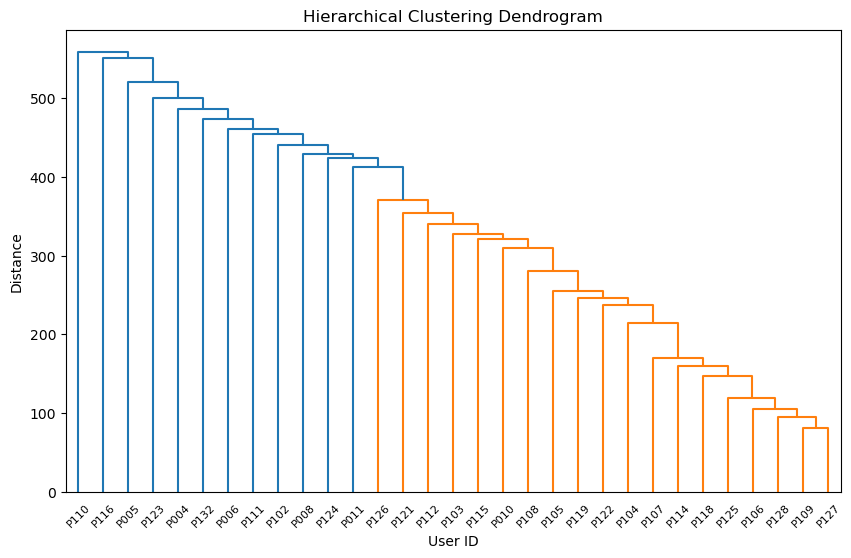

In [165]:
# Convert to a condensed distance matrix
condensed_distances = squareform(user_distances)
# Perform hierarchical clustering
linkage_matrix = linkage(condensed_distances, method='average')

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=list(dataframes.keys()))
plt.title("Hierarchical Clustering Dendrogram: Users")
plt.xlabel("User ID")
plt.ylabel("Distance")
plt.show()

Single

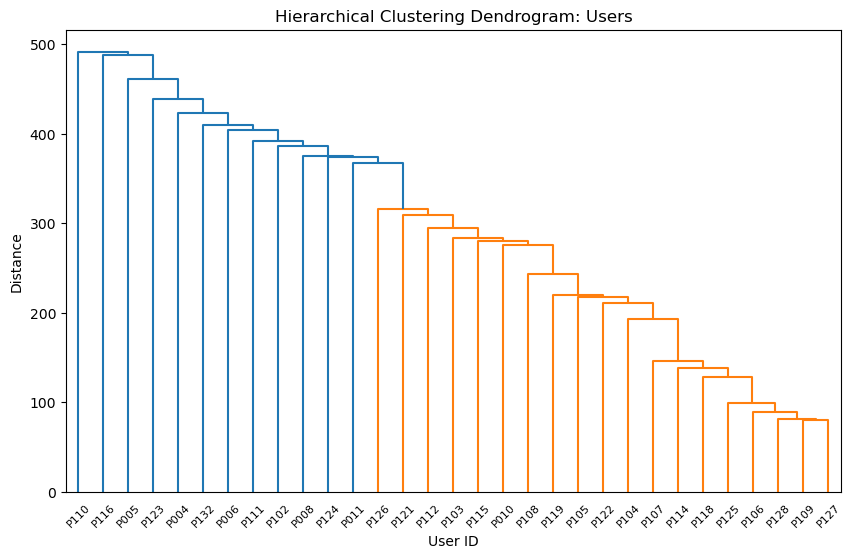

In [170]:
# Convert to a condensed distance matrix
condensed_distances = squareform(user_distances)
# Perform hierarchical clustering
linkage_matrix = linkage(condensed_distances, method='single')

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=list(dataframes.keys()))
plt.title("Hierarchical Clustering Dendrogram: Users")
plt.xlabel("User ID")
plt.ylabel("Distance")
plt.show()

Centroid

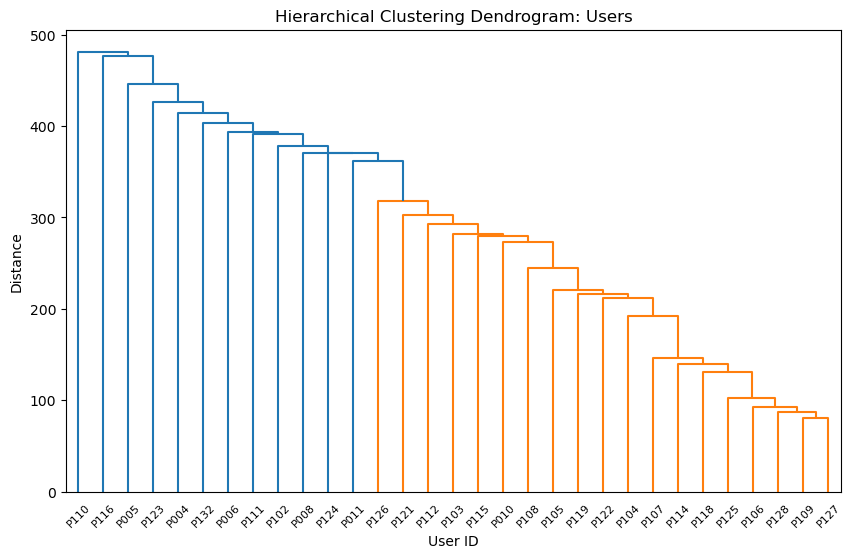

In [171]:
# Convert to a condensed distance matrix
condensed_distances = squareform(user_distances)
# Perform hierarchical clustering
linkage_matrix = linkage(condensed_distances, method='centroid')

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=list(dataframes.keys()))
plt.title("Hierarchical Clustering Dendrogram: Users")
plt.xlabel("User ID")
plt.ylabel("Distance")
plt.show()

In [ ]:
assert(False)

# Naive Approach: Full Dendrogram
This takes forever to run and can't really be visualized since there's 6000+ individual gestures (dendrogram is enormous, still not even sure if it can register. Kernel dies trying to render...

In [ ]:
print("Starting")

blocksize = 64
num_signal_features = 40
n_gestures = PCA_df.shape[0]//blocksize

# Reshape data to separate trials for each client
reshaped_data = PCA_df.iloc[:, 3:].to_numpy().reshape(n_gestures, blocksize, num_signal_features)
inter_subject_distances = np.zeros((n_gestures, n_gestures))
# Calculate pairwise distances between clients' trial data
start_time = time.time()
for i in range(n_gestures):
    if i%200==0:
        print(f"{i}/{n_gestures}")
    for j in range(i + 1, n_gestures): # Can skip i since it would just be 0 (eg the diagonal)
        distance = np.mean(np.linalg.norm(reshaped_data[i] - reshaped_data[j], axis=1))
        inter_subject_distances[i, j] = distance
        inter_subject_distances[j, i] = distance
print(f"Completed in {time.time() - start_time}s")

In [ ]:
# Convert inter-subject distances to a condensed distance matrix
condensed_distances = squareform(inter_subject_distances)

Kernel dies here...

In [ ]:
# Perform hierarchical clustering

start_time = time.time()

linkage_matrix_single = linkage(condensed_distances, method='single')
# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_single, labels=np.arange(num_gestures))
plt.title("Hierarchical Clustering Dendrogram: PCA 40D")
plt.xlabel("Gesture Index")
plt.ylabel("Distance")
plt.show()

print(f"Completed in {time.time() - start_time}s")

Does not handle data assymetries (eg different dataset sizes between clients)
- Should I calculate distances between clients, or between gestures? ... Ideally both...
- Gestures should be easy, it will just be ugly to visualize
- By client will be difficult because presumably clients have different numbers of trials/gestures present... not sure what to fill those missing ones with (presumably not just 0s since this is a distance matrix...)

In [ ]:
# This code is not ready to run yet... [trying to do it on the basis of user...]

n_clients = len(data_df['Participant'].unique())
n_trials = 8
# Flatten data for easy computation
flattened_data = np.vstack(data_clients2)
# Reshape data to separate trials for each client
reshaped_data = flattened_data.reshape(n_clients, n_trials, -1)
# Calculate pairwise distances between clients' trial data
inter_subject_distances = np.zeros((n_clients, n_clients))
for i in range(n_clients):
    for j in range(i + 1, n_clients):
        distance = np.mean(np.linalg.norm(reshaped_data[i] - reshaped_data[j], axis=1))
        inter_subject_distances[i, j] = distance
        inter_subject_distances[j, i] = distance
# Convert inter-subject distances to a condensed distance matrix
condensed_distances = squareform(inter_subject_distances)

# Perform hierarchical clustering
linkage_matrix_single = linkage(condensed_distances, method='single')
# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_single, labels=np.arange(n_clients))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Client Index")
plt.ylabel("Distance")
plt.show()